# Исследование спектра интегрального оператора

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size']=18

import scipy as sp

# Функция трехмерной структурированной сетки центров ячеек

In [2]:
def make_grid(N, L, center, **kwargs):
    """
    :param N: список из трех элементов [n_1, n_2, n_3] целых чисел, числа ячеек 
    дискретизации объемной области решения системой прямоугольных параллелепипедов
    :param L: список из трех элементов [l_1, l_2, l_3] вещественных чисел, длины
    дисркетизируемой объемной области решения по каждой из направления декартовой сетки координат
    :param center: список трех элементов [с_1, с_2, с_3] вещественных чисел расположения центра
    объемной области решения в трехмерной системы координат для вариации расположения области решения
    
    :return: (grid, volume), где grid - сетка в трехмерной системе координат с узловыми точками
    прямоугольных ячеек, volume - объем разбиения (прямоугольного параллелепипеда)
     """
    
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор, вытянутый в строку размером n*m*k
    grid = np.array(np.meshgrid(x, y, z, indexing='xy')).T.reshape(-1, 3)[:, [1, 0, 2]]
    
    return grid, volume

# Функция определения матрицы диэлектрической проницаемости среды

In [3]:
def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

# Функция Грина

In [4]:
def kernel(x, k=1):
    return np.exp(1j * k * x)/(4 * np.pi * x)

In [5]:
# Функция расчета коэффицентов-матриц дисркетного оператора B
def b_coeff(x, y, k, dv):
    diff = x - y
    R = np.sqrt(np.sum(diff * diff))
    alpha_n = diff / R
    alpha_nm = alpha_n[np.newaxis, :] * alpha_n[:, np.newaxis]
    delta = np.eye(3)
    gr = kernel(R, k)
    coef_1 = ((3/R) * (1/R) - (3 * 1.0j * k) / (R) - (k*k)) * alpha_nm
    coef_2 = ((k*k) + (1.0j * k) / R  - (1/R * 1/R)) * delta
    return gr * dv * (coef_1 + coef_2)


# Заполнение оператора B с матрицами диэлектрической проницаемости среды
def B_eta_operator_matrix(grid, eta, k, volume):
    # Расчет коэффициентов тензора B
    B_matrix = np.zeros((grid.shape[0], grid.shape[0], 3, 3)) + 0.0j
    for i in range(grid.shape[0]-1):
        for j in range(i+1, grid.shape[0]):
            B_matrix[i, j] = b_coeff(grid[i], grid[j], k, volume) @ eta[j]
            B_matrix[j, i] = b_coeff(grid[j], grid[i], k, volume) @ eta[i]

    for i in range(grid.shape[0]):
        B_matrix[i, i] = (-1/3) * np.eye(3) @ eta[i]
    return B_matrix


# Заполнение оператора B без матриц диэлектрической проницаемости среды
def B_operator_matrix(grid, k, volume):
    # Расчет коэффициентов тензора B
    B_matrix = np.zeros((grid.shape[0], grid.shape[0], 3, 3)) + 0.0j
    for i in range(grid.shape[0]-1):
        for j in range(i+1, grid.shape[0]):
            B_matrix[i, j] = b_coeff(grid[i], grid[j], k, volume)
            B_matrix[j, i] = b_coeff(grid[j], grid[i], k, volume)

    for i in range(grid.shape[0]):
        B_matrix[i, i] = (-1/3) * np.eye(3)
    return B_matrix

# Программа для определения формы и положения спектра оператора

In [10]:
# Вспомогательная подфункция для программы определения выпуклой оболочки спектра оператора
def cross(o, a, b):
    """
    Возвращает векторное произведение OA и OB
    Положительное значение означает поворот против часовой стрелки
    """
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


# Алгоритм последовательной цепи Эндрю для определения выпуклой оболочки множества точек спектра оператора на комплексной плоскости
def sequential_chain(points):
    """
    :points - список кортежей пар координат точек
    :Функция вычисляет минимальную выпуклую оболочку для заданного множества точек на плоскости
    методом последовательной цепи.
    :Возвращает список точек в порядке обхода оболочки.
    """

    # Сортируем точки лексикографически (по x, затем по y)
    points = sorted(set(points))
    if len(points) == 1:
        return points

    # Строим нижнюю оболочку
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Строим верхнюю оболочку
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # Соединяем верхнюю и нижнюю оболочки
    # Последняя точка каждого списка совпадает с первой точкой другого списка, поэтому исключаем их
    convex = lower[:-1] + upper[:-1]
    return convex


def mu_2points(lambda_1, lambda_2):
    """
    :param lambda_1:
    :param lambda_2:
    :return mu: complex value of circle center on a complex plane
    """
    a = (lambda_1 + lambda_2) / 2
    numerator = 1j * (np.imag(lambda_1 * np.conj(lambda_2)) * (lambda_2 - lambda_1))
    denominator = 2 * (np.abs(lambda_1 * np.conj(lambda_2)) + np.real(lambda_1 * np.conj(lambda_2)))
    mu = a + numerator / denominator
    return mu


def radius_2points(lambda_1, lambda_2):
    """
    :param lambda_1:
    :param lambda_2:
    :return:
    """
    numerator = np.abs(lambda_1 - lambda_2) ** 2 * np.abs(np.conj(lambda_1) * lambda_2)
    denominator = 2 * (np.abs(np.conj(lambda_1) * lambda_2) + np.real(np.conj(lambda_1) * lambda_2))
    radius = np.sqrt(np.real(numerator / denominator))
    return radius


def mu_3points(lambda_1, lambda_2, lambda_3):
    """
    :param lambda_1:
    :param lambda_2:
    :param lambda_3:
    :return:
    """
    numerator = (np.abs(lambda_1) ** 2 * (lambda_2 - lambda_3)
                 +
                 np.abs(lambda_2) ** 2 * (lambda_3 - lambda_1)
                 +
                 np.abs(lambda_3) ** 2 * (lambda_1 - lambda_2))
    denominator = 2 * np.imag(lambda_1 * np.conj(lambda_2)
                              +
                              lambda_2 * np.conj(lambda_3)
                              +
                              lambda_3 * np.conj(lambda_1))
    return 1j * numerator / denominator


def radius_3points(mu, lambda_):
    """

    :param mu:
    :param lambda_:
    :return:
    """
    return abs(mu - lambda_).real


def compute_circle_two_points(lambda_1, lambda_2):
    """

    :param lambda_1:
    :param lambda_2:
    :return:
    """
    center = mu_2points(lambda_1, lambda_2)
    radius = radius_2points(lambda_1, lambda_2)
    return center, radius


def compute_circle_three_points(lambda_1, lambda_2, lambda_3):
    """

    :param lambda_1:
    :param lambda_2:
    :param lambda_3:
    :return:
    """
    x1, y1 = lambda_1.real, lambda_1.imag
    x2, y2 = lambda_2.real, lambda_2.imag
    x3, y3 = lambda_3.real, lambda_3.imag

    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    if np.abs(d) < 1e-12:
        return 1.0+0.0j, 0.0  # Points are colinear or too close

    center = mu_3points(lambda_1, lambda_2, lambda_3)
    radius = radius_3points(center, lambda_1)
    return center, radius


def circle_contains_points(center, radius, points, epsilon = 1e-8):
    """

    :param center:
    :param radius:
    :param points:
    :param epsilon:
    :return:
    """
    return np.prod(np.abs(points - center) <= radius + epsilon) > 0


def circle_contains_origin(center, radius, epsilon = 1e-8):
    """

    :param center:
    :param radius:
    :param epsilon:
    :return:
    """
    return abs(center) <= radius + epsilon


def circle_angle_from_origin(center, radius):
    """

    :param center:
    :param radius:
    :return:
    """
    d = abs(center)
    if d <= radius:
        return np.pi  # Origin is inside the circle
    ratio = radius / d
    ratio = max(-1.0, min(1.0, ratio))  # Clamp to [-1, 1] to avoid math domain error
    theta = 2 * np.arcsin(ratio)
    return theta


def find_params(points):
    """

    :param points:
    :return:
    """
    # Step 1:
    for point1, point2 in np.array(np.meshgrid(points, points)).T.reshape(-1, 2):
        center, radius = compute_circle_two_points(point1, point2)
        if circle_contains_points(center, radius, points):
            print(f"Circle center: {center}, radius: {radius}")
            print(f"Two points, point1: {point1}, point2: {point2}")
            return center, radius,

    # Step 2:
    best_theta = None
    best_circle = None
    for point1, point2, point3 in np.array(np.meshgrid(points, points, points)).T.reshape(-1, 3):
        center, radius = compute_circle_three_points(point1, point2, point3)
        if circle_contains_points(center, radius, points) and \
                not circle_contains_origin(center, radius):
            theta = circle_angle_from_origin(center, radius)
            if best_theta is None or theta < best_theta:
                best_theta = theta
                best_circle = (center, radius)

    if best_circle:
        center, radius = best_circle
        print(f"Circle center: {center}, radius: {radius}")
        return center, radius
    else:
        print("No circle found.")
        return 1.0 + 0.0j, 0.0

In [11]:
# Функция для распаковки тензора (N, N, m, m) -> (N*m, N*m)
def flatten_block_matrix(M4d):
    """
    Раскрывает 4D-блочную матрицу формы (N, N, m, m)
    в большую 2D-матрицу (N*m, N*m).
    """
    N, N2, m, m2 = M4d.shape
    assert N == N2 and m == m2, "Должно быть (N, N, m, m)."
    # Склеиваем оси (N, m) для строк, и (N, m) для столбцов
    return M4d.transpose(0,2,1,3).reshape(N*m, N*m)

In [17]:
# Размерность задачи
N = [6, 6, 6]

# Настройки быстрого умножения
n_1 = N[0]
n_2 = N[1]
n_3 = N[2]
to_shape_mul = (n_3, n_1, n_2)

# Объем области Q
L = [1, 1, 1]

# Центр области Q
center = [0.0, 0.0, 0.0]

# Задание индекса eta(x) для точек внутри Q 
eps_vec = [
            {
                "type": "step",
                "eps_real": [[4.0, 0.0, 0.0],
                             [0.0, 3.0, 0.0],
                             [0.0, 0.0, 2.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            }
        ]

# Волновое число задачи
k=0.0

In [18]:
# Расчет сетки дискретизации
grid, volume = make_grid(N = N, L = L, center = center)
grid

# Расчет расстояний на сетке дискретизации
dists = np.linalg.norm(grid[0] - grid, axis=1)

# Ассоциация точкам сетки диэлектрической проницаемости
eta, ind = apply_dielectric_3d(grid, eps_vec)
eta = eta - np.eye(3)[np.newaxis, :, :]

# Расчет блочной операторной матрицы B 
B_matrix = B_eta_operator_matrix(grid, eta, k, volume)

# Вычитаем единичную матрицу из B*eta
Bt = np.eye(np.prod(N) * 3) - flatten_block_matrix(B_matrix)

# Расчет собственных значений оператора встроенной программой
result_eigs = np.linalg.eigvals(Bt)

# Список собственных значений матричного оператора
print("Собственные значения матрицы оператора")
print(result_eigs[-10:])

Собственные значения матрицы оператора
[1.21257187-1.39638408e-16j 1.21307207+9.35467882e-17j
 1.2122494 +2.11660654e-16j 1.20094746-7.11263567e-17j
 1.11164558-4.01678549e-20j 1.11175622-1.40946832e-18j
 1.17954196+9.91425491e-24j 1.18636615-3.61669897e-23j
 1.21293576-7.62865534e-23j 1.21304824-4.02378238e-23j]


In [19]:
# Поиск выпуклой оболочки спектрального множества
list_of_points = [(x.real, x.imag) for x in result_eigs]
hull = sequential_chain(list_of_points)
hull_eigs = np.array([x[0] + 1.0j * x[1] for x in hull])
print("\nВыпуклая оболочка спектра", hull_eigs)

# Центр и радиус для параметров итерационного метода
mu, radius = find_params(hull_eigs)
# Оценка сходимости
rho = np.arctan(radius/np.abs(mu))/2

print("\nЦентр окружности", mu)
print("Радиус окружности", radius)
print("Знаменатель сходимости", rho)


Выпуклая оболочка спектра [0.80204922-2.69180096e-17j 1.05609962-6.17053835e-16j
 1.21877423-8.26783839e-16j 1.48766064-9.22550245e-16j
 2.61989667-9.01242869e-16j 4.09917988+3.36252140e-29j
 2.50897509+7.79955235e-16j 1.87967698+9.70370692e-16j
 1.50013336+8.36024703e-16j 1.14944197+4.92666666e-16j
 0.94120508+2.18711347e-16j]
Circle center: (2.450614554390626-4.11232029941399e-17j), radius: 1.648565330249315
Two points, point1: (0.8020492241413111-2.69180096042196e-17j), point2: (4.099179884639941+3.362521398718174e-29j)

Центр окружности (2.450614554390626-4.11232029941399e-17j)
Радиус окружности 1.648565330249315
Знаменатель сходимости 0.2960891377554393


In [20]:
# Краткая статистика по спектру
minRe = np.min(result_eigs.real) 
maxRe = np.max(result_eigs.real)
minIm = np.min(result_eigs.imag)
maxIm = np.max(result_eigs.imag)
print(r"Минимальное вещественное значение $min Re \sigma$=" + f"{minRe.round(4)}")
print(r"Максимальное вещественное значение $max Re \sigma$=" + f"{maxRe.round(4)}")
print(r"Минимальное мнимое значение $min Im \sigma$=" + f"{minIm.round(4)}")
print(r"Максимальное мнимое значение $min Im \sigma$=" + f"{maxIm.round(4)}")

Минимальное вещественное значение $min Re \sigma$=0.802
Максимальное вещественное значение $max Re \sigma$=4.0992
Минимальное мнимое значение $min Im \sigma$=-0.0
Максимальное мнимое значение $min Im \sigma$=0.0


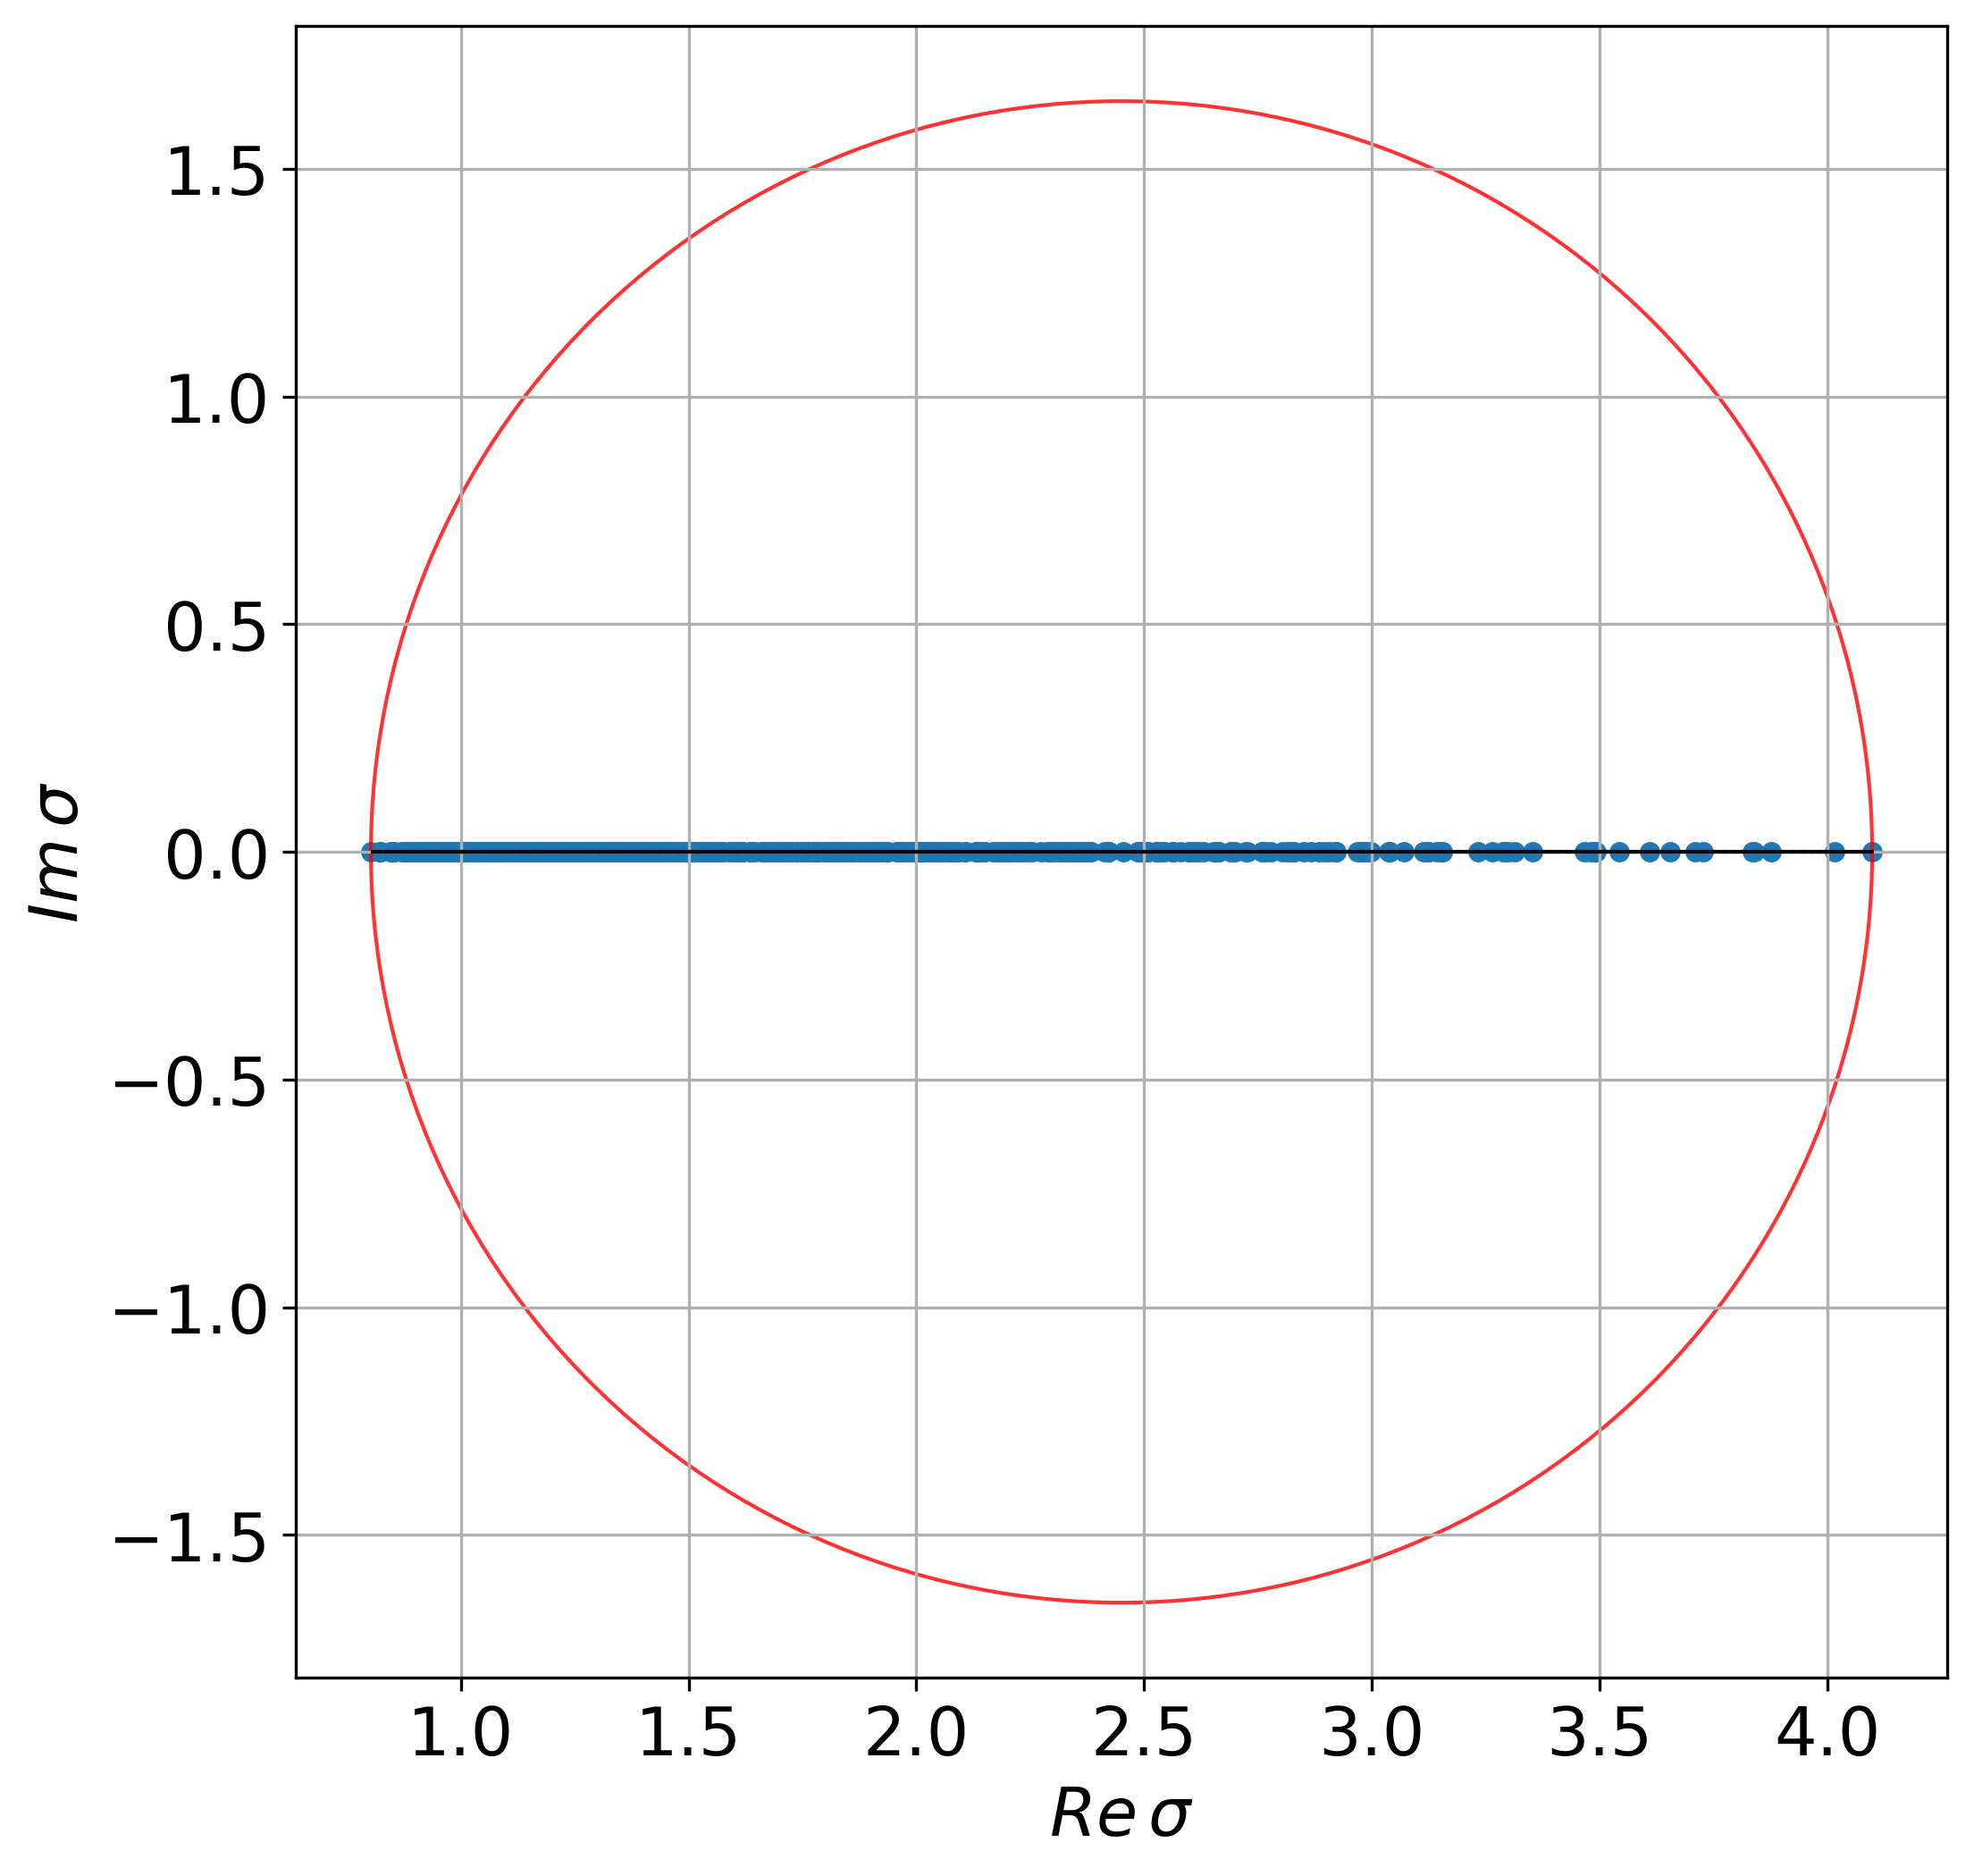

In [21]:
# Задание графика на холсте
plt.figure(figsize=(8,8), dpi=300)
plt.gca().set_aspect('equal')

# Визуализация спектра оператора на комплексной плоскости
plt.scatter(result_eigs.real, result_eigs.imag,s=20, label = r"$\sigma$")
#plt.xlim((-max(maxRe, maxIm)/4, max(maxRe, maxIm) + 1))   # Границы отрисовки
#plt.ylim((-max(maxRe, maxIm), max(maxRe, maxIm)))      # Границы отрисовки

# Визуализация выпуклой оболочки спектра
plt.plot(hull_eigs.real, hull_eigs.imag, c="black", linestyle="--", linewidth=1, label="hull")
plt.plot(hull_eigs.real[[-1, 0]], hull_eigs.imag[[-1, 0]], c="black", linestyle="--", linewidth=1)

circle1 = plt.Circle((mu.real, mu.imag), radius, color='r', fill=False, alpha=0.8, label="($\mu$, R)")
plt.gca().add_patch(circle1)

plt.xlabel(r"$Re\,\sigma$")
plt.ylabel(r"$Im\,\sigma$")

plt.grid()
#plt.legend()
plt.show()

# Реализация метода простой итерации для матрицы

In [2130]:
# Функция расчета векторной нормы для комплекснозначных векторов
def complex_norm(f):
    return np.sqrt(np.sum(f * np.conj(f)).real)


# Расчет дискретизированного оператора в матричной форме
def operator_matrix(matrix, eta, vector):
    # Вычисление (eta * vector) поэлементно
    result = np.einsum("...ij,...j->...i", eta, vector)
    
    # Вычисление матрично-векторной операции B @ (eta * vector)
    result = np.einsum("ijkl,jl->ik", matrix, vector)
    
    # Вычитание vector - B @ (eta * vector)
    result = vector - result
    return result


# реализация метода простой итерации для матричной формы оператора
def SIM_matrix(matrix, vector_f, vector_eta, param_mu=None, u0=None, max_iter=100, tol=1e-8):
    # Списки для сохранения невязок и итераций
    resid_hist = []
    iters_hist = []
    delta_hist = []
    
    # Начальные значения с точки 0
    if u0 is None:
        u0 = np.zeros_like(vector_f) + 0.0j
        
    # Если mu не задан, устанавливаем значение 1
    if param_mu is None:
        param_mu = 1.0 + 0.0j
        
    # Подсчет нормы вектора свободных коэффициентов
    norm_f = complex_norm(vector_f)
    
    # Итерации метода
    for it in range(1 + max_iter + 1): # k=1,2,...,max_iter
        # Результат вычисления оператора с шагом приближения
        op_res = operator_matrix(matrix, vector_eta, u0)
        # подсчет невязки
        resid = op_res - vector_f
        # Следующее приближение по итерациям
        u1 = u0 - 1/(param_mu) * resid
        # Норма невязки
        resid_norm = complex_norm(resid)/norm_f
        # Вычисление дельты приближения
        delta = complex_norm(u1 - u0) / norm_f
        
        # Сохранение исторических значений итераций для графиков
        print(f"Итерация={it}, delta={delta}, resid={resid_norm}")
        resid_hist.append(resid_norm)
        iters_hist.append(it)
        delta_hist.append(delta)
        
        # остановка итераций
        if delta < tol:
            break
        # Копирование вектора
        u0 = np.copy(u1)
        
    return u1, iters_hist, delta_hist, resid_hist

In [2131]:
def wave(x, k=1, orient=[0.0, 0.0, 1.0], sign=1, amplitude=[1.0, 0.0, 0.0], phi0=0.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    amplitude = np.array(amplitude)
    return amplitude.reshape(-1, 3) * np.exp(sign * 1j * k * (x.dot(orient)) - phi0).reshape(-1, 1)

f_wave = wave(grid, k, [1.0, 0.0, 0.0], 1, [0.0, 1.0, 0.0])

In [2132]:
# Расчет коэффициентов тензора B
B_matrix = B_operator_matrix(grid, k, volume)

In [2133]:
result_SIMm, iters_SIMm, delta_SIMm, resid_SIMm = SIM_matrix(B_matrix, f_wave, eta, mu)

Итерация=0, delta=0.13172624000148153, resid=1.0
Итерация=1, delta=0.10806741951301435, resid=0.8203940195347479
Итерация=2, delta=0.09156970072079368, resid=0.6951515561346304
Итерация=3, delta=0.07977641838312907, resid=0.6056228309730226
Итерация=4, delta=0.07096317416173106, resid=0.5387170708048217
Итерация=5, delta=0.06400715881649732, resid=0.4859104671611171
Итерация=6, delta=0.058224845229870974, resid=0.4420140226367663
Итерация=7, delta=0.05322077957171263, resid=0.4040256487326599
Итерация=8, delta=0.04877302539087587, resid=0.3702605144603483
Итерация=9, delta=0.044757539626436874, resid=0.3397769466883248
Итерация=10, delta=0.04110265832952421, resid=0.312030908413251
Итерация=11, delta=0.0377634800663789, resid=0.28668153031585936
Итерация=12, delta=0.034708246344404094, resid=0.2634877177395615
Итерация=13, delta=0.03191152058917296, resid=0.24225636888150795
Итерация=14, delta=0.02935102449444301, resid=0.22281835793774188
Итерация=15, delta=0.02700633337643902, resid=

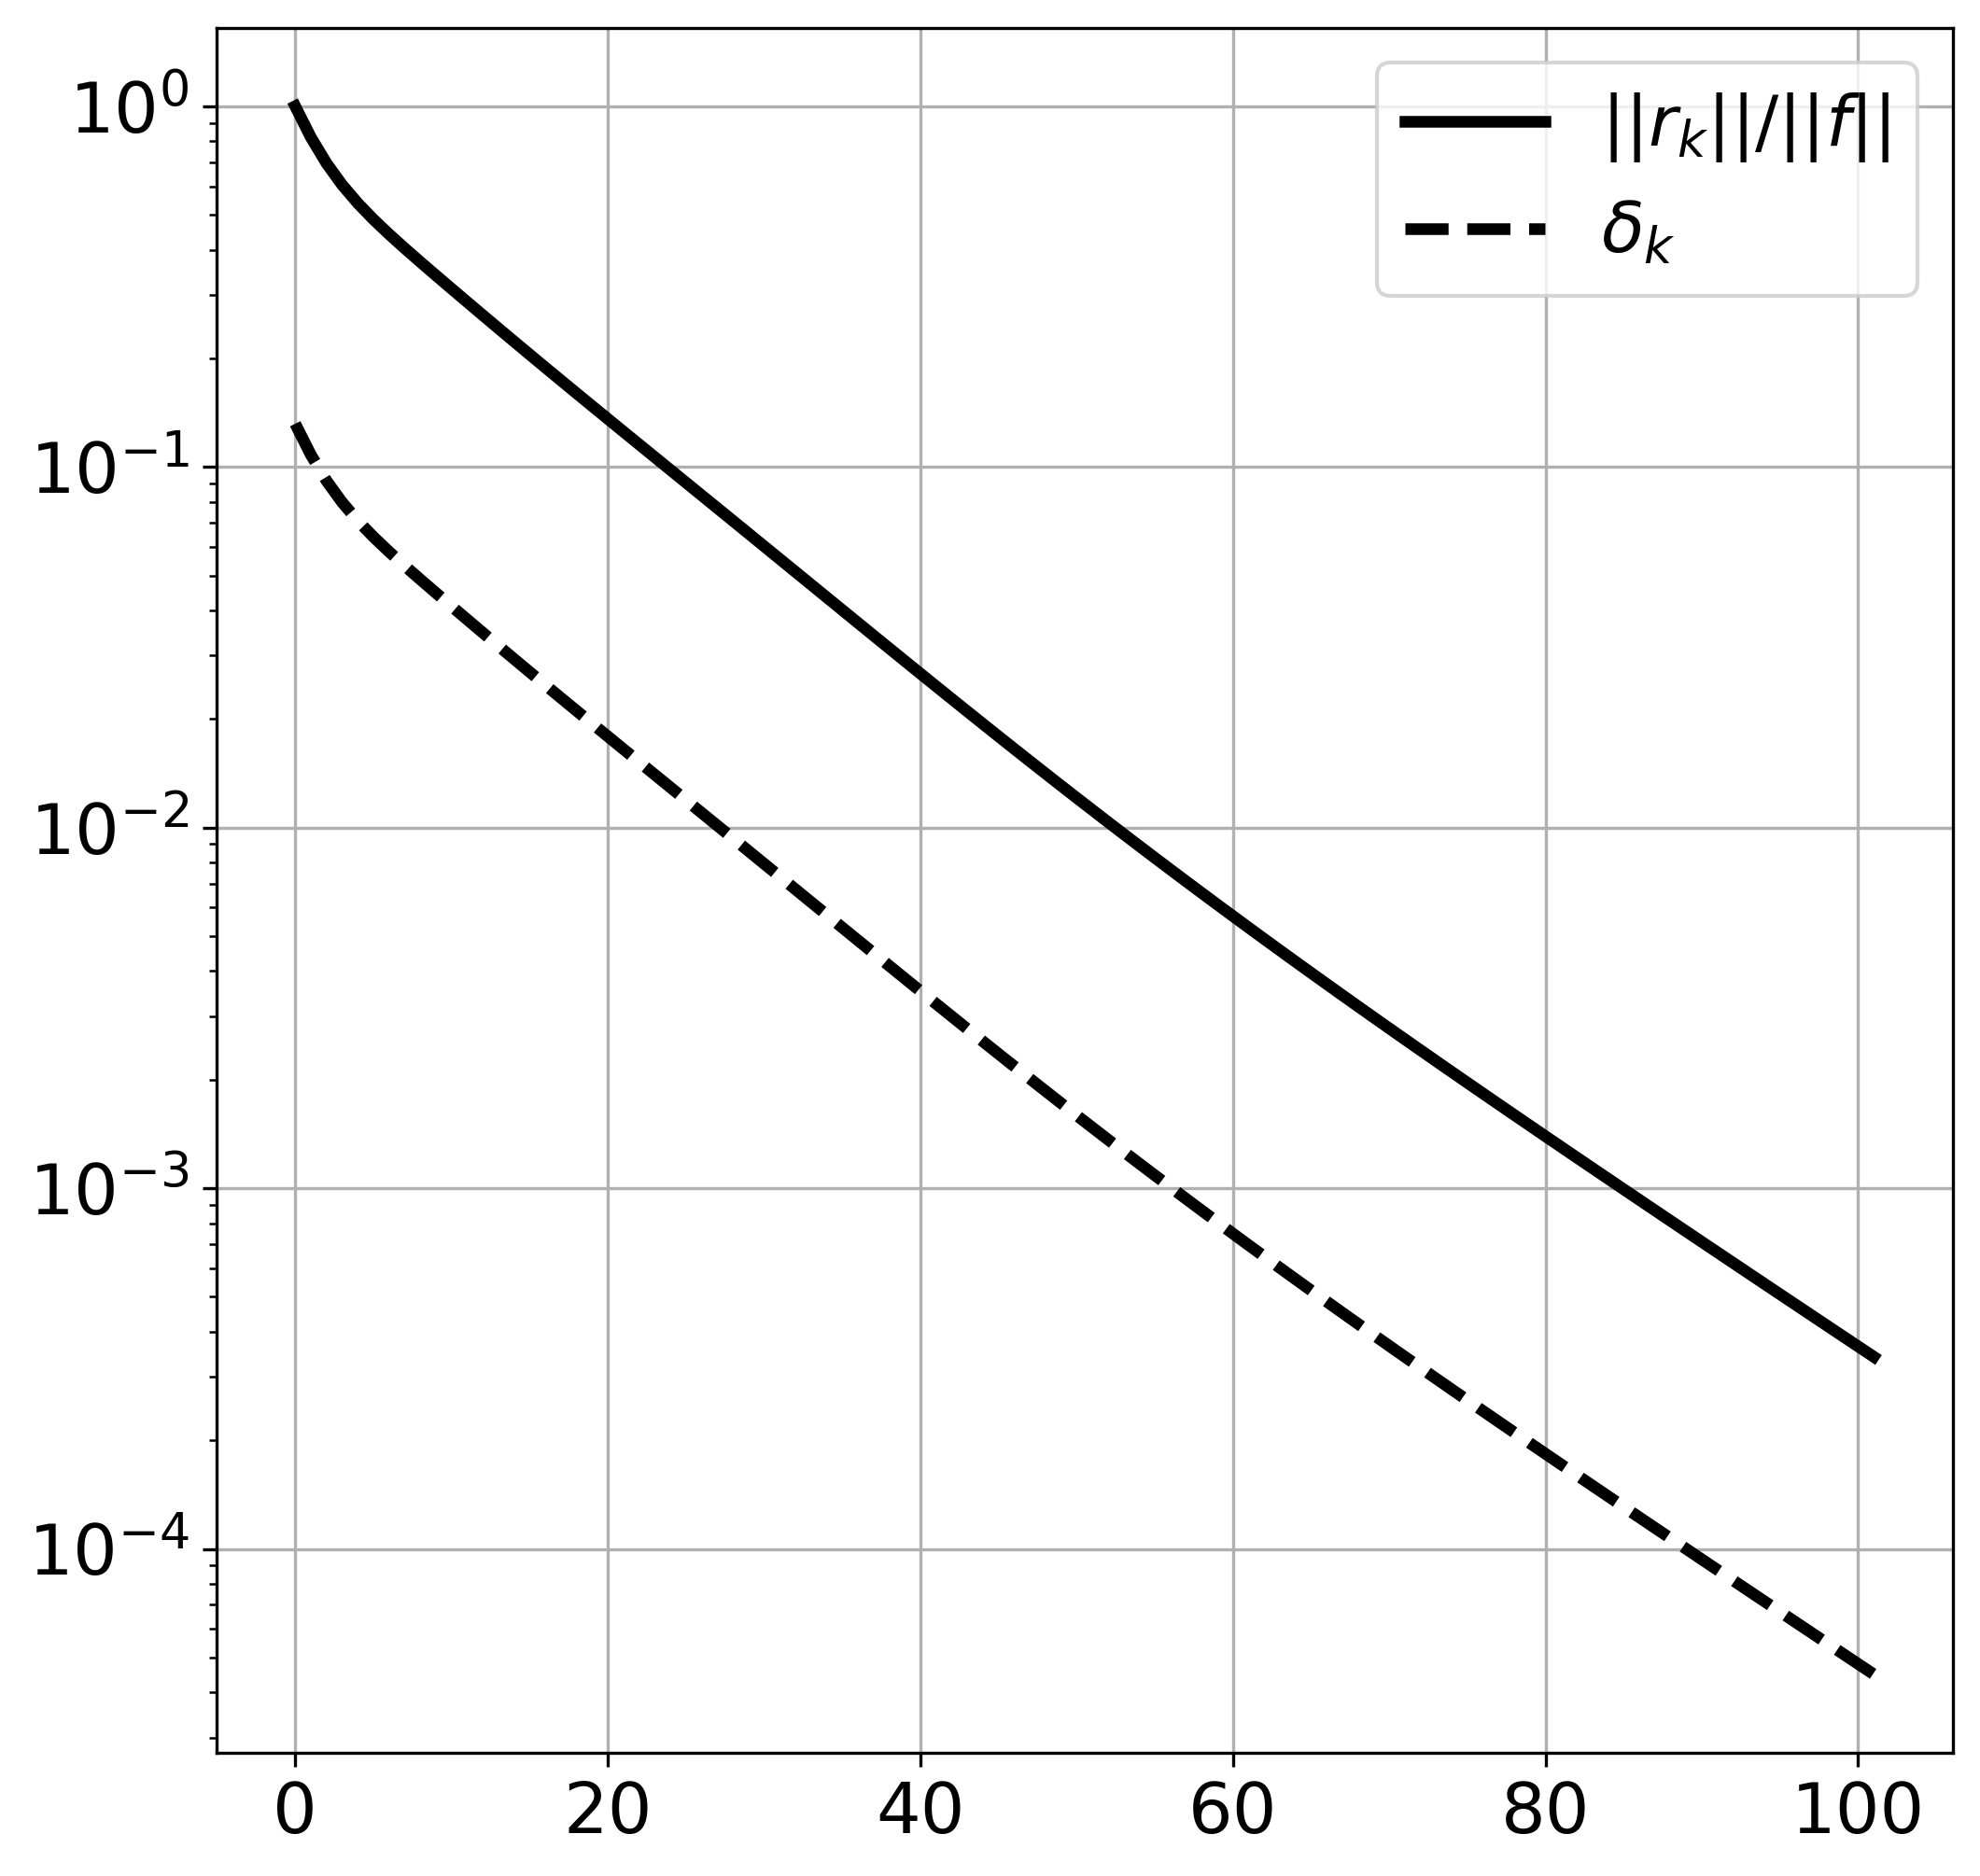

In [2134]:
# Отрисовка результатов итераций на малой сетке при найденном параметре
plt.figure(figsize=(8,8), dpi=300)
plt.plot(iters_SIMm, resid_SIMm, label=r"$||r_k|| / ||f||$", linewidth=3, c="black")
plt.plot(iters_SIMm, delta_SIMm, label=r"$\delta_k$", linewidth=3, linestyle="--", c="black")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

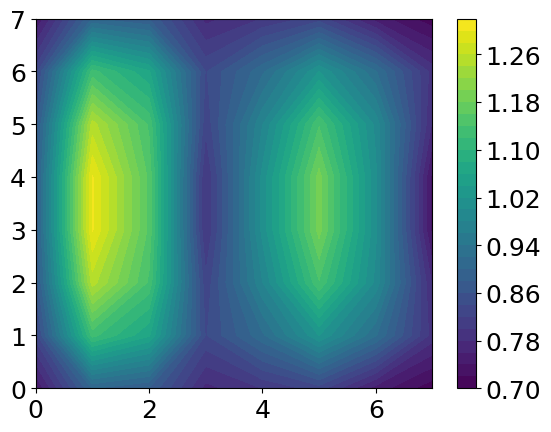

In [2136]:
plt.contourf(np.linalg.norm(result_SIMm.reshape(N+[3]), axis=3)[0, :, :].real, 30)
plt.colorbar()

# Быстрые умножения

In [2240]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :param k:
    :return:
    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n, :m, :k]


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    """

    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    """

    """
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]

# Определение ядра интегрального оператора

$$
    B_{nm}(p-q) = \int_{\Pi_q} G(R) \left[(\frac{3}{R^2} - \frac{3ik_0}{R} - k_0^2)\alpha_n \alpha_m + (k_0^2 + \frac{ik_0}{R}-\frac{1}{R^2})\delta_{nm} \right] dy, p\ne q
$$

$$
\alpha_n = \frac{x_n(p)-y_n}{|x(p)-y|}, n=1,2,3, \quad \eta_{mk} = \varepsilon(y(q)) - \delta_{mk}, \quad R = \sqrt{\sum_{i=1}^{3} {(y_i - x_i(p))^2}}, \quad B_{nm}(0,0,0) = (-1/3)I
$$


In [2241]:
def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)

def init_operator(grid, volume, discret, distance, k, eps, kernel):
    dist_coef_1 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_1[1:] = (3 / (distance[1:] ** 2)) - ((3j * k) / distance[1:]) - (k ** 2)
    alpha = np.zeros((np.prod(discret), 3))
    alpha[1:, :] = (grid[0, :] - grid[1:, :]) / distance[1:].reshape(-1, 1)
    indexing_matrix = np.einsum('...j,...i->...ji', alpha, alpha)
    part_1 = indexing_matrix * dist_coef_1.reshape(-1, 1, 1)

    dist_coef_2 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_2[1:] = (k ** 2) + ((1j * k) / distance[1:]) - (1 / (distance[1:] ** 2))
    part_2 = np.eye(3).reshape(-1, 3, 3) * dist_coef_2.reshape(-1, 1, 1)

    gr = np.zeros(np.prod(discret)) + 0.0j
    gr[1:] = kernel(distance[1:], k)
    result = gr.reshape(-1, 1, 1) * (part_1 + part_2) * volume.reshape(-1, 1)
    eps = eps.reshape(-1, 3, 3) - (np.eye(3).reshape(-1, 3, 3))
    result[0, :, :] = -(1 / 3) * np.eye(3)
    return result, gr, eps

In [2242]:
def fast_block_t_matvec(G, u):
    """
    Быстрое умножение блочно-Тёплицевой матрицы G (с 3×3 блоками)
    на вектор (3-мерный в каждой точке) u.
    
    ПАРАМЕТРЫ:
    ----------
    G : ndarray, shape = (n1, n2, n3, 3, 3)
        Генератор блочно-Тёплицевой матрицы в виде 3D ядра с блоками 3×3.
    u : ndarray, shape = (n1, n2, n3, 3)
        Входной вектор (фактически 3D-тензор), в каждой точке
        3-мерный “под-вектор”.
    
    ВОЗВРАЩАЕТ:
    -----------
    y : ndarray, shape = (n1, n2, n3, 3)
        Результат G * u, то есть блочно-Тёплицевое произведение.
    """
    n1, n2, n3, _, _ = G.shape
    
    for i_block in range(3):
        # аккумулируем сумму по j
        acc = np.zeros((n1*2, n2*2, n3*2), dtype=np.complex128)
        for j_block in range(3):
            acc += G_kern[i_block, j_block] * u_fft[j_block]
    
    y = np.zeros((n1, n2, n3, 3), dtype=np.complex128)
    for i_block in range(3):
        y[..., i_block] = y_pad[i_block, :n1, :n2, :n3]
    
    return y

In [2243]:
def fast_3d_block_toeplitz_matvec(G, u):
    """
    Быстрое умножение блочно-Тёплицевой матрицы G (с 3×3 блоками)
    на вектор (3-мерный в каждой точке) u.
    
    ПАРАМЕТРЫ:
    ----------
    G : ndarray, shape = (n1, n2, n3, 3, 3)
        Генератор блочно-Тёплицевой матрицы в виде 3D ядра с блоками 3×3.
    u : ndarray, shape = (n1, n2, n3, 3)
        Входной вектор (фактически 3D-тензор), в каждой точке
        3-мерный “под-вектор”.
    
    ВОЗВРАЩАЕТ:
    -----------
    y : ndarray, shape = (n1, n2, n3, 3)
        Результат G * u, то есть блочно-Тёплицевое произведение.
    """
    n1, n2, n3, _, _ = G.shape
    
    # ----------------------------------------------------------------
    # 2) Подготовим массивы для FFT:
    # G_kern[i, j] будет 3D-ядром для преобразования канала j->i.
    # То есть G_kern[i, j].shape = (N1, N2, N3).
    # Будем хранить это в одном массиве G_kern размерности (3, 3, N1, N2, N3)
    
    G_kern = np.zeros((3, 3, n1*2, n2*2, n3*2), dtype=np.complex128)
    
    # Разместим исходное ядро G в "углу" массива G_kern с нулями для паддинга.
    # Для каждого блока (i, j) из {0,1,2} заполним:
    for i_block in range(3):
        for j_block in range(3):
            # Копируем G[:,:, :, i_block, j_block] в начало соответствующего 
            # массива G_kern[i_block, j_block,:,:,:]
            G_kern[i_block, j_block] = prep_fftbbtensor(G[..., i_block, j_block], 
                                                        G[..., i_block, j_block], 
                                                        n1, n2, n3)
    
    # ----------------------------------------------------------------
    # 3) Аналогично подготовим u для каждого канала j -> массив u_pad[j].
    # В u у нас 3 канала/компоненты (последнее измерение).
    # Будем хранить в u_pad[j] shape = (N1, N2, N3).
    
    u_pad = np.zeros((3, n1*2, n2*2, n3*2), dtype=np.complex128)
    
    for j_block in range(3):
        u_pad[j_block, :n1, :n2, :n3] = u[..., j_block]
    
    # ----------------------------------------------------------------
    # 4) Выполним FFT по каждому каналу ядра и входа.
    #    np.fft.fftn(..., axes=(...)) можно и без осей, тогда по всем измерениям.
    
    u_fft = np.zeros_like(u_pad)
    for j_block in range(3):
        u_fft[j_block] = np.fft.fftn(u_pad[j_block])
    
    # ----------------------------------------------------------------
    # 5) Теперь, чтобы получить выходной результат y_i (i-ый канал),
    #    нам нужно просуммировать G_kern_fft[i, j] * u_fft[j] по j = 0..2
    #    и затем сделать обратное FFT.
    
    # Заведём массив для результата в частотной области, а потом выполним iFFT
    y_fft = np.zeros((3, n1*2, n2*2, n3*2), dtype=np.complex128)
    
    for i_block in range(3):
        # аккумулируем сумму по j
        acc = np.zeros((n1*2, n2*2, n3*2), dtype=np.complex128)
        for j_block in range(3):
            acc += np.fft.ifftn(G_kern[i_block, j_block] * u_fft[j_block])
        y_fft[i_block] = acc
    
    # Выполним обратное FFT, получим «распаддинный» результат
    y_pad = np.zeros_like(y_fft)
    for i_block in range(3):
        y_pad[i_block] = y_fft[i_block]
    
    # ----------------------------------------------------------------
    # 6) «Обрезаем» (crop) результат до (n1, n2, n3) по каждому каналу i.
    #    Здесь важно аккуратно смотреть, какова точная интерпретация границ,
    #    нужна ли циклическая свертка или «обычная» свертка, и т.п.
    #    Для иллюстрации возьмём просто левый верхний угол:
    
    y = np.zeros((n1, n2, n3, 3), dtype=np.complex128)
    for i_block in range(3):
        y[..., i_block] = y_pad[i_block, :n1, :n2, :n3]
    
    return y


In [2244]:
fast_mult = fast_3d_block_toeplitz_matvec(G.reshape((*to_shape_mul, 3, 3), order="C"), f_wave.reshape((*to_shape_mul, 3))).reshape(-1, 3)

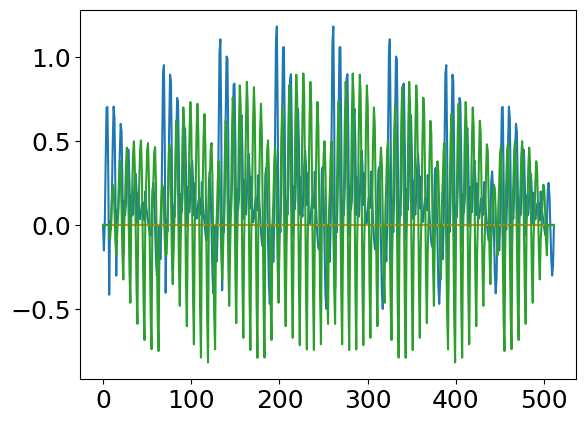

In [2245]:
plt.plot(fast_mult - result_mult_classic)

In [2246]:
def operator(operator_array, vector_array, eps, n, m, k):
    result = np.zeros((n * m * k, 3)) + 0.0j
    vec_array = np.einsum("...jk,...k->...j", eps, vector_array)
    for col in range(3):
        result[:, 0] += prep_fbbtmv(prep_fft_arr=operator_array[:, col].reshape((2 * n, 2 * m, 2 * k)),
                          vec_arr=vec_array[:, col].reshape((n, m, k)),
                          n=n, m=m, k=k).reshape((-1,))
    for col in range(3):
        result[:, 1] += prep_fbbtmv(prep_fft_arr=operator_array[:, 3 + col].reshape((2 * n, 2 * m, 2 * k)),
                                    vec_arr=vec_array[:, col].reshape((n, m, k)),
                                    n=n, m=m, k=k).reshape((-1,))
    for col in range(3):
        result[:, 2] += prep_fbbtmv(prep_fft_arr=operator_array[:, 6 + col].reshape((2 * n, 2 * m, 2 * k)),
                                    vec_arr=vec_array[:, col].reshape((n, m, k)),
                                    n=n, m=m, k=k).reshape((-1,))

    result = vector_array - result
    return result

# Скрипт решения задачи

In [2247]:
# Конфиг задачи
problem_config = {
    'N': [8, 8, 8],
    'L': [1.0, 1.0, 1.0],
    'center': [0.0, 0.0, 0.0],
    'k': 6.0,
    'orient': [0.0, 1.0, 0.0],
    'amplitude': [1.0, 0.0, 0.0],
    'sign': 1.0,
    'eps_vec': [
        {
                "type": "step",
                "eps_real": [[4.0, 0.0, 0.0],
                             [0.0, 3.0, 0.0],
                             [0.0, 0.0, 2.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
k_wave = problem_config.get('k')

grid,volume = make_grid(**problem_config)
eta, ind = apply_dielectric_3d(grid, **problem_config)
dists = np.linalg.norm(grid[0, :] - grid[:,:], 2, axis=1)
G, gr, eps = init_operator(grid, volume, problem_config.get('N'), dists, problem_config.get('k'), eta, kernel)

In [2248]:
np.sum(np.abs(G - B_matrix[:, 0]))

6.603742110085726e-16

In [2249]:
result_mult_classic = np.einsum("ijkl,jl->ik", B_matrix, f_wave)

In [2250]:
# нужно получить быстрыми умножениями
result_mult_classic[:, 0]

array([ 1.01702389e-01-0.10365298j,  2.01559609e-01+0.02851018j,
        7.85605414e-02+0.20358203j, -1.96518281e-01+0.25988514j,
       -4.51606388e-01+0.11553509j, -5.02167330e-01-0.17500162j,
       -2.60759889e-01-0.44265899j,  2.07874434e-01-0.494789j  ,
        8.82171267e-02-0.01744093j,  6.62120608e-02+0.05279532j,
       -4.97686772e-02+0.12334176j, -2.27578343e-01+0.11460135j,
       -3.62488729e-01-0.00925857j, -3.47762535e-01-0.20312417j,
       -1.48806972e-01-0.35854228j,  1.53586541e-01-0.36891594j,
        5.25940675e-02+0.00869848j,  1.11969591e-02+0.04147118j,
       -7.23817940e-02+0.06403629j, -1.74547708e-01+0.03968511j,
       -2.38599822e-01-0.04401863j, -2.10712499e-01-0.15725257j,
       -8.05611881e-02-0.23940591j,  1.00509725e-01-0.23536415j,
        1.69314022e-02+0.00583831j, -1.01823776e-03+0.01514224j,
       -3.12913455e-02+0.01949627j, -6.48656603e-02+0.00822761j,
       -8.36115510e-02-0.02135632j, -7.12321149e-02-0.05882673j,
       -2.58175601e-02-0.

In [2261]:
result_fast = (
fast_bbtmv_mul(col_arr = G[:, 0, 0].reshape(n_3, n_1, n_2), 
               row_arr = G[:, 0, 0].reshape(n_3, n_1, n_2), 
               vec_arr = f_wave[:, 0].reshape(n_3, n_1, n_2), 
               n = n_3, m = n_1, k = n_2)    
    +
fast_bbtmv_mul(col_arr = G[:, 0, 1].reshape(n_3, n_1, n_2), 
               row_arr = G[:, 0, 1].reshape(n_3, n_1, n_2), 
               vec_arr = f_wave[:, 1].reshape(n_3, n_1, n_2), 
               n = n_3, m = n_1, k = n_2)
    
    +
fast_bbtmv_mul(col_arr = G[:, 0, 2].reshape(n_3, n_1, n_2), 
               row_arr = G[:, 0, 2].reshape(n_3, n_1, n_2), 
               vec_arr = f_wave[:, 2].reshape(n_3, n_1, n_2), 
               n = n_3, m = n_1, k = n_2) 
)

In [2287]:
fast_bbtmv_mul(col_arr = B_matrix[0, :, 0, 1].reshape(n_3, n_1, n_2), 
               row_arr = B_matrix[0, :, 0, 1].reshape(n_3, n_1, n_2), 
               vec_arr = f_wave[:, 1].reshape(n_3, n_1, n_2), 
               n = n_3, m = n_1, k = n_2)

array([[[ 0.10170239-0.10365298j,  0.04919406-0.15931795j,
          0.08789998-0.20792874j,  0.18172486-0.15543499j,
          0.2473745 +0.02876698j,  0.20077846+0.28255995j,
          0.02140365+0.47734696j, -0.20787443+0.494789j  ],
        [ 0.11115187-0.19955304j,  0.03899423-0.260077j  ,
          0.11382091-0.30127851j,  0.25207341-0.21086825j,
          0.34267459+0.03482013j,  0.29021278+0.35355112j,
          0.08441971+0.59689513j, -0.14862151+0.64462891j],
        [ 0.13930139-0.23843562j,  0.04918679-0.28159534j,
          0.10645017-0.32118977j,  0.24808447-0.23681041j,
          0.36386749+0.01099009j,  0.3464341 +0.35226324j,
          0.16661655+0.63971632j, -0.07331004+0.73904876j],
        [ 0.15810604-0.25124804j,  0.055644  -0.28212264j,
          0.09643628-0.32268326j,  0.23499358-0.24863848j,
          0.36642046-0.00808712j,  0.37581941+0.34087935j,
          0.21741854+0.65395939j, -0.02580411+0.78652918j],
        [ 0.15810604-0.25124804j,  0.055644  -0.2821

In [2280]:
np.einsum("ij,j->i", B_matrix[:, :, 0, 0], f_wave[:, 0])

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
      

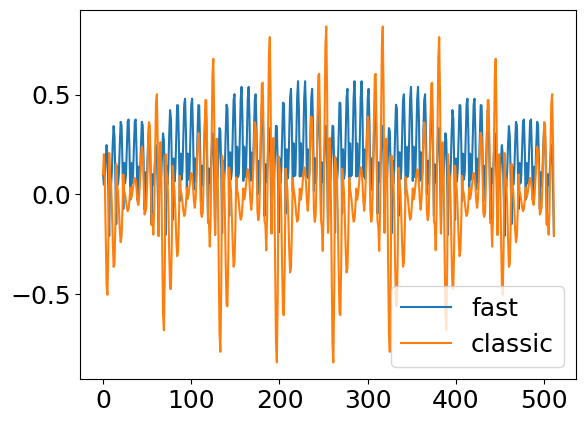

In [2278]:
plt.plot(result_fast.reshape(-1), label="fast")
plt.plot(np.einsum("ijk,jk->i", B_matrix[:, :, 0, :], f_wave), label="classic")
plt.legend()